# Models Baselines

- Gabriel Wendell Celestino Rocha
---

### 0. Imports and Path Setup

In [50]:
import sys, os 
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

sys.path.append(os.path.abspath("../"))
from src.models.cnn1d_temporal import CNN1DTemporal
from src.tda.spatial_embedding import spatial_delay_embedding
from src.tda.persistence_tools import compute_vr_persistence, betti_curves_from_diagrams

# Make plots nicer
import smplotlib
def opt_plot_axs(ax):
    ax.grid(True, linestyle = ':', color = '0.50')
    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.size'] = 15
    ax.minorticks_on()
    ax.tick_params(axis = 'both', which = 'minor', direction = "in",
                        top = True, right = True, length = 5, width = 1, labelsize = 15)
    ax.tick_params(axis = 'both', which = 'major', direction = "in",
                        top = True, right = True, length = 8, width = 1, labelsize = 15)
    
def opt_plot():
    plt.grid(True, linestyle = ':', color = '0.50')
    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.size'] = 15
    plt.minorticks_on()
    plt.tick_params(axis = 'both', which = 'minor', direction = "in",
                        top = True, right = True, length = 5, width = 1, labelsize = 15)
    plt.tick_params(axis = 'both', which = 'major', direction = "in",
                        top = True, right = True, length = 8, width = 1, labelsize = 15)

---

### 1. General Configurations

#### Fix a device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


#### Load your processed tensors

In [3]:
data = np.load("../data/processed/brio_wu_tensors.npz")

X = data["X"]        # Shape (T-1, 2, Nx)
Y = data["Y"]        # Shape (T-1, 2, Nx)
times = data["times"]     # Length T
x_grid = data["x"]        # Length Nx

print("X shape:", X.shape, "Y shape:", Y.shape)

X shape: (40, 2, 1000) Y shape: (40, 2, 1000)


#### Convert to float32 Torch tensors

In [4]:
X_torch = torch.from_numpy(X.astype(np.float32))
Y_torch = torch.from_numpy(Y.astype(np.float32))

#### Dataset & Dataloaders

In [5]:
class BrioWuTemporalDataset(Dataset):
    def __init__(self, X_tensor: torch.Tensor, Y_tensor: torch.Tensor):
        assert X_tensor.shape == Y_tensor.shape
        self.X = X_tensor
        self.Y = Y_tensor

    def __len__(self):
        return self.X.shape[0]  # Number of time pairs (T-1)

    def __getitem__(self, idx):
        # Return (input, target)
        return self.X[idx], self.Y[idx]


dataset = BrioWuTemporalDataset(X_torch, Y_torch)
n_total = len(dataset)
print("Total pairs:", n_total)

# Split e.g. 32 train / 8 val if n_total = 40
n_train = int(0.8 * n_total)
n_val = n_total - n_train

generator = torch.Generator().manual_seed(42)
train_set, val_set = random_split(dataset, [n_train, n_val],
                                  generator = generator)

batch_size = 8
train_loader = DataLoader(train_set, batch_size = batch_size,
                          shuffle = True)
val_loader = DataLoader(val_set, batch_size = batch_size,
                        shuffle = False)

len(train_set), len(val_set)

Total pairs: 40


(32, 8)

### 2. Instantiate Model, Loss and Optimizer

In [6]:
Nx = X.shape[-1]

model = CNN1DTemporal(in_channels = 2, hidden_channels = 32, kernel_size = 5)
model = model.to(device)

criterion = nn.MSELoss()   # Averaged over batch and all entries
optimizer = optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-6)

---

### 3. Training loop (with simple early stopping)

In [7]:
def train_model(model, train_loader, val_loader,
                criterion, optimizer,
                num_epochs = 800,
                patience = 50):
    train_losses = []
    val_losses = []

    best_val_loss = np.inf
    best_state = None
    epochs_without_improvement = 0

    for epoch in range(1, num_epochs + 1):
        # ---- Training ----
        model.train()
        running_train = 0.0
        for X_batch, Y_batch in train_loader:
            X_batch = X_batch.to(device)  # (B, 2, Nx)
            Y_batch = Y_batch.to(device)

            optimizer.zero_grad()
            Y_pred = model(X_batch)
            loss = criterion(Y_pred, Y_batch)
            loss.backward()
            optimizer.step()

            running_train += loss.item() * X_batch.size(0)

        epoch_train_loss = running_train / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # ---- Validation ----
        model.eval()
        running_val = 0.0
        with torch.no_grad():
            for X_batch, Y_batch in val_loader:
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device)
                Y_pred = model(X_batch)
                loss = criterion(Y_pred, Y_batch)
                running_val += loss.item() * X_batch.size(0)

        epoch_val_loss = running_val / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        # ---- Early stopping tracking ----
        if epoch_val_loss < best_val_loss - 1e-6:
            best_val_loss = epoch_val_loss
            best_state = model.state_dict()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epoch % 50 == 0 or epoch == 1:
            print(f"Epoch {epoch:4d} | "
                  f"train MSE = {epoch_train_loss:.4e} | "
                  f"val MSE = {epoch_val_loss:.4e}")

        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    # Restore best model
    if best_state is not None:
        model.load_state_dict(best_state)

    return model, np.array(train_losses), np.array(val_losses)

#### Run Training

If you want a log scale plot:
```python
plt.figure(figsize = (6,4))
plt.semilogy(train_losses, label = "Train")
plt.semilogy(val_losses, label = "Val")
plt.xlabel("Epoch")
plt.ylabel("MSE (log scale)")
plt.legend(loc = "best")
plt.tight_layout()
opt_plot()
plt.show()
```

Epoch    1 | train MSE = 7.3836e-01 | val MSE = 8.1359e-01
Epoch   50 | train MSE = 8.9294e-02 | val MSE = 1.2331e-01
Epoch  100 | train MSE = 8.2783e-02 | val MSE = 1.1606e-01
Epoch  150 | train MSE = 7.8036e-02 | val MSE = 1.0989e-01
Epoch  200 | train MSE = 7.6037e-02 | val MSE = 1.0861e-01
Epoch  250 | train MSE = 7.5459e-02 | val MSE = 1.0550e-01
Epoch  300 | train MSE = 7.3327e-02 | val MSE = 1.0436e-01
Epoch  350 | train MSE = 7.1749e-02 | val MSE = 1.0241e-01
Epoch  400 | train MSE = 7.2681e-02 | val MSE = 1.0285e-01
Epoch  450 | train MSE = 7.2048e-02 | val MSE = 1.0397e-01
Epoch  500 | train MSE = 7.1433e-02 | val MSE = 1.0307e-01
Epoch  550 | train MSE = 7.4247e-02 | val MSE = 1.0353e-01
Epoch  600 | train MSE = 6.9940e-02 | val MSE = 1.0016e-01
Epoch  650 | train MSE = 6.9119e-02 | val MSE = 9.9184e-02
Epoch  700 | train MSE = 6.8064e-02 | val MSE = 9.8679e-02
Epoch  750 | train MSE = 6.8996e-02 | val MSE = 9.9490e-02
Epoch  800 | train MSE = 7.9070e-02 | val MSE = 1.0584e-

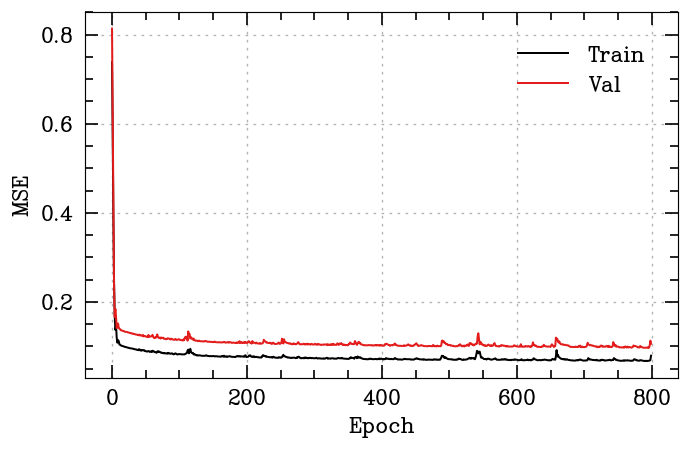

In [8]:
model, train_losses, val_losses = train_model(
    model, train_loader, val_loader,
    criterion, optimizer,
    num_epochs = 800,
    patience = 80,
)

# Plot loss curves
plt.figure(figsize = (6,4))
plt.plot(train_losses, label = "Train")
plt.plot(val_losses, label = "Val")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend(loc = "best")
plt.tight_layout()
opt_plot()
plt.show()

#### Save the Trained Model

In [9]:
os.makedirs("../results/models", exist_ok = True)
torch.save(model.state_dict(), "../results/models/cnn1d_temporal_baseline.pt")

---

### 4. Evaluation & Visualization of Baseline

### 4.1 One-step Predictions for All Pairs

In [10]:
model.eval()
with torch.no_grad():
    X_all = X_torch.to(device)       # (T-1, 2, Nx)
    Y_true_all = Y_torch.to(device)
    Y_pred_all = model(X_all).cpu().numpy()   # Back to NumPy
    Y_true_all_np = Y_true_all.cpu().numpy()

Remember:
- pair index $k$ corresponds to $t_{k}\rightarrow t_{k+1}$, so:
> - `times_pairs = times[:-1]` (inputs),
> - `times_next = times[1:]` (targets).

### 4.2 Helper: True  vs Predicted Profiles for a Few Times

In [11]:
def plot_true_vs_pred(k, field = "rho"):
    """
    k : index of pair (0..T-2), i.e. predicting t_{k+1} from t_k.
    field: 'rho' or 'p'
    """
    assert field in ("rho", "p")
    ch = 0 if field == "rho" else 1

    t_in = times[k]
    t_out = times[k+1]

    y_true = Y_true_all_np[k, ch]  # (Nx,)
    y_pred = Y_pred_all[k, ch]     # (Nx,)

    plt.figure(figsize = (6,4))
    plt.plot(x_grid, y_true, "k-", label = "True")
    plt.plot(x_grid, y_pred, "r--", label = "Predicted")
    plt.xlabel(r"$x$")
    plt.ylabel(f"{field}_norm")
    plt.title(f"{field.upper()} at $t=$ {t_out:.2f} "
              f"(Predicted from $t=$ {t_in:.2f})")
    plt.legend(loc = "best")
    plt.tight_layout()
    opt_plot()
    plt.show()

    # Residuals
    plt.figure(figsize = (6,4))
    plt.plot(x_grid, y_pred - y_true, "b-")
    plt.axhline(0.0, color = "k", linewidth = 0.8)
    plt.xlabel(r"$x$")
    plt.ylabel(r"Pred $-$ True")
    plt.title(f"Residuals {field.upper()} at $t=$ {t_out:.2f}")
    plt.tight_layout()
    opt_plot()
    plt.show()

This should clearly show where the CNN:

- smooths shocks,
- slightly misplaces fronts,
- performs well in smooth regions.

### 4.3 Multi-step (iterated) Forecasting

We now start from a single snapshot and iterate the model forward in time, feeding its own outputs back in.

In [12]:
def forecast_multi_step(model, X0, n_steps):
    """
    X0     : (2, Nx) tensor, initial snapshot at t_0
    n_steps: number of steps to forecast (Δt each)

    Returns: array of shape (n_steps+1, 2, Nx)
             containing [X0, X1_pred, X2_pred, ...]
    """
    model.eval()
    preds = []
    x_curr = X0.to(device).unsqueeze(0)  # (1, 2, Nx)

    with torch.no_grad():
        preds.append(x_curr.squeeze(0).cpu().numpy())
        for _ in range(n_steps):
            x_next = model(x_curr)
            preds.append(x_next.squeeze(0).cpu().numpy())
            x_curr = x_next

    return np.stack(preds, axis = 0)  # (n_steps+1, 2, Nx)

**Example:** start from physical $t=0$ snapshot and forecast $10$ steps:

In [13]:
X0 = X_torch[0]          # Snapshot at t = times[0]
n_steps = 10             # Predicts up to t = times[10]
traj_pred = forecast_multi_step(model, X0, n_steps)

print("traj_pred shape:", traj_pred.shape)  # (11, 2, Nx)

traj_pred shape: (11, 2, 1000)


Compare with ground truth:

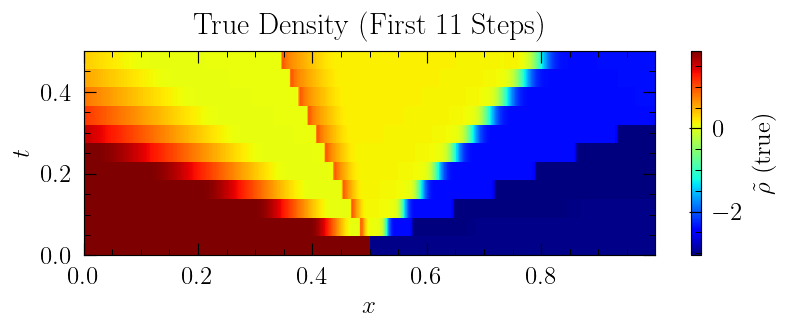

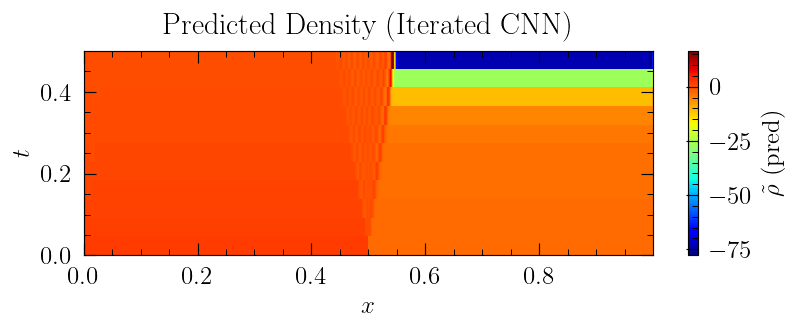

In [27]:
rho_true_seq = data["rho_norm"][:n_steps+1]  # (n_steps+1, Nx)
p_true_seq   = data["p_norm"][:n_steps+1]

rho_pred_seq = traj_pred[:, 0, :]
p_pred_seq   = traj_pred[:, 1, :]

# Example: x–t diagrams
plt.figure(figsize = (7,3))
plt.imshow(rho_true_seq, aspect = "auto", origin = "lower",
           extent = [x_grid[0], x_grid[-1], times[0], times[n_steps]])
plt.colorbar(label = "$\\tilde{\\rho}$ (true)")
plt.xlabel(r"$x$"); plt.ylabel(r"$t$")
plt.title("True Density (First 11 Steps)")
plt.tight_layout()
plt.show()

plt.figure(figsize = (7,3))
plt.imshow(rho_pred_seq, aspect = "auto", origin = "lower",
           extent = [x_grid[0], x_grid[-1], times[0], times[n_steps]])
plt.colorbar(label = "$\\tilde{\\rho}$ (pred)")
plt.xlabel(r"$x$"); plt.ylabel(r"$t$")
plt.title("Predicted Density (Iterated CNN)")
plt.tight_layout()
plt.show()

---

## 5.  Error Heatmaps

Use normalized density (since your CNN trained on normalized fields).

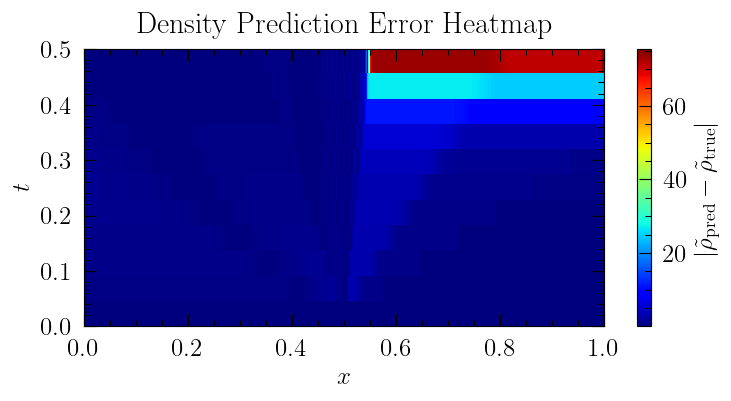

In [30]:
# True and predicted density sequences (normalized)
#rho_true_seq = rho_true_seq[:-1]          # shape (T-1, Nx)
#rho_pred_seq = rho_pred_seq               # shape (T-1, Nx)

# Compute error
rho_err = np.abs(rho_pred_seq - rho_true_seq)

plt.figure(figsize = (7,3))
plt.imshow(rho_err, aspect = 'auto', origin = 'lower',
           extent = [0, 1, 0, 0.5],  # Adjust if needed
           cmap = 'jet')
plt.colorbar(label = r'$|\tilde{\rho}_{\mathrm{pred}} - \tilde{\rho}_{\mathrm{true}}|$')
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Density Prediction Error Heatmap')
plt.show()

#### Some definitions before running the prediction-TDA block

In [46]:
# --- Load ground-truth TDA parameters used in notebook 03 ---
data = np.load("../data/processed/brio_wu_tensors.npz")

T = data["rho_norm"].shape[0]          # should be 41
Nx = data["rho_norm"].shape[1]

# radius grid used in ground-truth TDA
n_radii = 100
eps_max = 6.0
radii = np.linspace(0.0, eps_max, n_radii)

m_star = 5      # Chosen embedding dimension (from Phase 2)
tau_star = 2    # Chosen lag
stride = 2      # Same used in ground truth

#### TDA of CNN Predictions

In [53]:
betti_curves = np.zeros((T-1, len(radii), 2))   # Store β0 and β1

m = 4
tau = 2
stride = 2
dim = 1
dt = 0.1

T_pred = rho_pred_seq.shape[0]

betti0_pred = np.zeros((T_pred, len(radii)))
betti1_pred = np.zeros((T_pred, len(radii)))

for k in range(T_pred):
    field = rho_pred_seq[k]
    
    pc = spatial_delay_embedding(field, m = m, tau = tau, stride = stride)
    
    diagrams = compute_vr_persistence(pc, maxdim = dim)
    betti_dict = betti_curves_from_diagrams(diagrams, radii, maxdim = dim)
    
    betti0_pred[k] = betti_dict[0]
    betti1_pred[k] = betti_dict[1]

#### Create Heatmaps

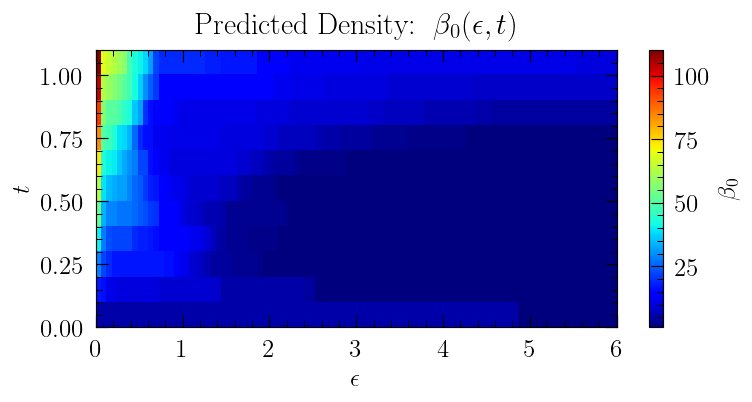

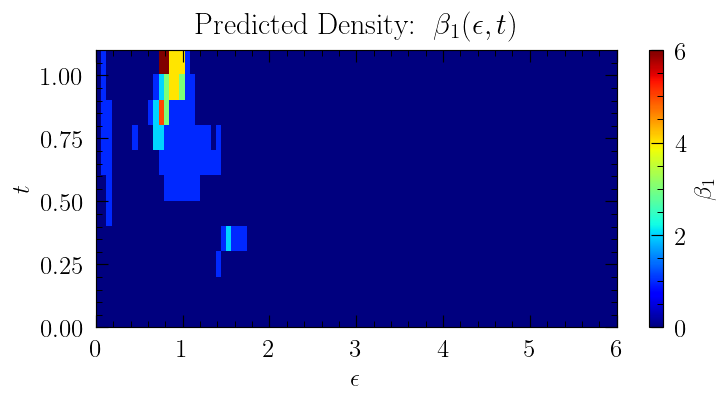

In [54]:
plt.figure(figsize = (7,3))
plt.imshow(betti0_pred, aspect = 'auto', origin = 'lower',
           extent = [0, eps_max, 0, T_pred*dt])
plt.colorbar(label = r'$\beta_0$')
plt.xlabel('$\epsilon$')
plt.ylabel('$t$')
plt.title('Predicted Density: $\\,\\beta_0(\epsilon, t)$')
plt.show()

plt.figure(figsize = (7,3))
plt.imshow(betti1_pred, aspect = 'auto', origin = 'lower',
           extent = [0, eps_max, 0, T_pred*dt])
plt.colorbar(label = r'$\beta_1$')
plt.xlabel('$\epsilon$')
plt.ylabel('$t$')
plt.title('Predicted Density: $\\,\\beta_1(\epsilon, t)$')
plt.show()

---